In [1]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
import wave
import pylab
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import copy
import math

In [2]:
# Has to be created locally since google dataset is local

POSITIVE_DIRECTORY = "../raw_data/positive_data/"
BACKGROUND_DIRECTORY = "../raw_data/background_data/"
NEGATIVES_DIRECTORY = "../raw_data/google_dataset/"
AUDIO_IGNORED_EXAMPLES_DIRECTORY = "../audio_ignored_examples/"

POSITIVE_EXAMPLE = "jh_1.wav"
BACKGROUND_EXAMPLE = "bg_10.wav"

AUDIO_EXAMPLE = "example_train.wav"

## General Approach

The general idea is randomly iterate through each word directory, randomly select a recording from each word directory, and concatenating the words to form a ten second continuous stream of words.

For now, collect 9 words, select a background, put the 9 words inside, put basically inside.

In [3]:
NEGATIVES_FILENAMES = [name for name in os.listdir(NEGATIVES_DIRECTORY) if os.path.isdir(os.path.join(NEGATIVES_DIRECTORY, name)) 
                       and '_' not in name]
NEGATIVES_AUDIONAMES = {}
for file in NEGATIVES_FILENAMES:
    NEGATIVES_AUDIONAMES[file] = [name for name in os.listdir(NEGATIVES_DIRECTORY + file + "/") if name.endswith("wav")]
POSITIVES_AUDIONAMES = [name for name in os.listdir(POSITIVE_DIRECTORY) if name.endswith("wav")]
BACKGROUND_AUDIONAMES = [name for name in os.listdir(BACKGROUND_DIRECTORY) if name.endswith("wav")]

In [4]:
Tx = 5490 # Based on created training example
n_freq = 129 # Based on created training example
Ty = 1369 # Based on model.summary() in 1.4 with shape := (Tx, n_freq)

In [5]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

def random_negatives(negative_audionames, n, debug=False):
    """
    Given a python dictionary of all audio names in negative files
    Return a list of n randomly selected negative audios
    """
    
    # find n random files
    random_files = np.random.choice(list(negative_audionames.keys()), n, replace=False)
    output = []
    if debug:
        print("Selecting {} negative audio files randomly:".format(n))
    audio_length = 0
    for file in random_files:
        audio_names = negative_audionames[file]
        # from each file generate a random audio
        random_audio = np.random.choice(audio_names, 1)[0]
        if debug:
            print("    - from {}: {}".format(file, random_audio))
        # load the chosen audio
        global NEGATIVES_DIRECTORY
        link = NEGATIVES_DIRECTORY + file + "/" + random_audio
        audio = AudioSegment.from_wav(link)
        audio_length += len(audio)
        output.append(audio)
    return output, audio_length

def random_positives(positives_audionames, n, debug=False):
    """
    Given a list of positive audio names
    Return a list of 0-4 randomly selected positive audios
    """
    
    # generate n random audios
    random_audios = np.random.choice(positives_audionames, n, replace=False)
    output = []
    if debug:
        print("Selecting {} positive audio files randomly:".format(n))
    audio_length = 0
    for name in random_audios:
        if debug:
            print("    - {}".format(name))
        # load audio
        global POSITIVE_DIRECTORY
        link = POSITIVE_DIRECTORY + name
        audio = AudioSegment.from_wav(link)
        audio_length += len(audio)
        output.append(audio)
    return output, audio_length

def random_background(background_audionames, debug=False):
    """
    Given a list of background audio names
    Return a randomly selected background audio
    """
    # generate a random audio
    random_audio = np.random.choice(background_audionames, 1, replace=False)[0]
    if debug:
        print("Selecting background file randomly:\n    - {}".format(random_audio))
    # load audio
    global BACKGROUND_DIRECTORY
    link = BACKGROUND_DIRECTORY + random_audio
    return AudioSegment.from_wav(link)

In [6]:
def create_training_example(id, prefix, num_positives, debug=False):
    """
    Creates a training examples with a given background, positives, and negatives with id.
    
    Arguments:
    id -- an id is given such that the new files does not replace the previous files
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    negatives, neg_len = random_negatives(NEGATIVES_AUDIONAMES, 10 - num_positives, debug)
    positives, pos_len = random_positives(POSITIVES_AUDIONAMES, num_positives, debug)
    background = random_background(BACKGROUND_AUDIONAMES, debug)
    
    # Make background quieter
    background = background - 30
    
    # Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))
    
    # Squeeze in as many negatives as possible within 10 seconds
    total_len = neg_len + pos_len
    while total_len > 10000:
        to_remove = np.random.randint(0, len(negatives))
        negatives.pop(to_remove)
        total_len = pos_len
        for audio in negatives:
            total_len += len(audio)

    # Randomly insert positives into negatives
    insertion_points = list(np.random.choice(list(range(len(negatives)+1)), len(positives), replace=False))
    insertion_points.sort()
    num_inserted = 0
    inserted_points = []
    
    # for debugging
    test_pos = ["+1","+2","+3","+4"]
    test_neg = ["-"] * len(negatives)

    while len(insertion_points) > 0:
        insertion_point = insertion_points.pop(0) + num_inserted
        negatives.insert(insertion_point, positives[num_inserted])
        test_neg.insert(insertion_point, test_pos[num_inserted])
        num_inserted += 1
        inserted_points.append(insertion_point)
    
    if debug:
        print("Points of insertion: {}".format(inserted_points))
        print("Visualization: {}".format(test_neg))
    
    # Concatenate audios and insert labels
    continuous = negatives[0]
    audio_length = len(continuous)
    if 0 in inserted_points:
        y = insert_ones(y, segment_end_ms=len(continuous))

    for i in range(1,len(negatives)):
        continuous += negatives[i]
        # insert label
        if i in inserted_points:
            y = insert_ones(y, segment_end_ms=len(continuous))


    # Superpose audio segment and background
    result = background.overlay(continuous, position = 0)
    # trim off any excess
    result = result[:10000]

    # Export new training example 
    result = result.set_channels(1)
    result = result.set_frame_rate(123000)
    
    file_handle = result.export(AUDIO_IGNORED_EXAMPLES_DIRECTORY + prefix + "_" + str(id) + ".wav", format="wav")
    if debug:
        print("File (train_" + str(id) + ".wav) was saved in" + AUDIO_IGNORED_EXAMPLES_DIRECTORY)

    sample_rate, samples = wavfile.read(AUDIO_IGNORED_EXAMPLES_DIRECTORY + prefix + "_" + str(id) +".wav")
    frequencies, times, x = signal.spectrogram(samples, sample_rate)
    
    return frequencies, times, x, y

Selecting 8 negative audio files randomly:
    - from go: 735845ab_nohash_0.wav
    - from off: 1b459024_nohash_0.wav
    - from nine: a3fc7884_nohash_1.wav
    - from four: 3df9a3d4_nohash_0.wav
    - from marvin: ce7a8e92_nohash_0.wav
    - from one: f0ebef1b_nohash_0.wav
    - from no: 6736bc64_nohash_1.wav
    - from stop: baf01c1f_nohash_1.wav
Selecting 2 positive audio files randomly:
    - aru_3.wav
    - aru_8.wav
Selecting background file randomly:
    - bg_18.wav
Points of insertion: [6, 9]
Visualization: ['-', '-', '-', '-', '-', '-', '+1', '-', '-', '+2']
File (train_1.wav) was saved in../audio_ignored_examples/
x: (129, 5490)
y: (1, 1369)


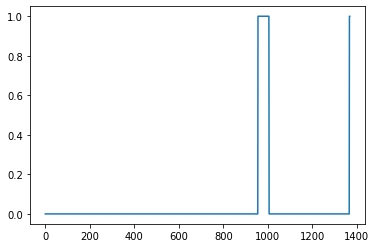

In [14]:
# Test
frequencies, times, x, y = create_training_example(1, "train", 2, debug=True)
print("x: {}".format(x.shape))
print("y: {}".format(y.shape))
plt.plot(y[0])

In [15]:
# prefix refers to the prefix naming of output audio files
def create_X_Y(size, start, prefix, mean_positives=2, variance=1):
    i, X, Y = 1, [], []
    for i in range(start, start + size):
        num_positives = int(random.gauss(mean_positives, variance))
        while num_positives < 0 or num_positives > 9: # prevent negative numbers and max number of words
            num_positives = int(random.gauss(mean_positives, variance))
        frequencies, times, x, y = create_training_example(i, prefix, num_positives)
        x = np.transpose(x)
        y = np.transpose(y)
        X.append(x)
        Y.append(y)
    return (np.array(X), np.array(Y))

## Dataset Generation

Training data is generated 1000 examples at a time since there is not enough RAM on my computer :( Either ways, we can still do incremental training of the model per batch of 1000 training examples.

In [16]:
X, Y = create_X_Y(50, 0, "test", mean_positives=2, variance=1)
print("X:{} Y:{}".format(X.shape, Y.shape))

X:(50, 5490, 129) Y:(50, 1369, 1)


In [17]:
np.save("../training_data/X_test.npy", X)
np.save("../training_data/Y_test.npy", Y)

## Possible Improvements:
- Randomly insert miliseconds of spaces within each sound to fully fill up all the 10 seconds.
- Try to cut off the positives' empty sounds at the start and at the end. There are only so few positives so might be possible to manually do it